In [1]:
import seaborn as sbn
import pairtools
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define functions

In [2]:
def loadPairsGenerator(path, n=0.1):
    header, pairs_body = pairtools._headerops.get_header(
        pairtools._fileio.auto_open(path, 'r'))
    cols = pairtools._headerops.extract_column_names(header)
    frame = pd.read_csv(pairs_body, sep="\t", names=cols,
                        iterator=True,
                        chunksize=1000000)
    for i, chunk in enumerate(frame):
        if i % 100 == 0:
            print("Processing chunk:", i)
        yield chunk.sample(frac=n)


def loadPairs(path, n=0.1):
    gen = loadPairsGenerator(path, n=n)
    out = []
    for chunk in gen:
        out.append(chunk)
    return pd.concat(out)


def downSamplePairs(sampleDict, Distance: int = 10**4):
    """Will downsample cis and trans reads in sampleDict to contain
    as many combined cis and trans reads as the sample with the lowest readnumber of the
    specified distance. """
    # initialize output dictionary
    outDict = {sample: {} for sample in sampleDict}
    for sample in sampleDict.keys():
        outDict[sample] = sampleDict[sample].copy()
        # filter on distance
        outDict[sample] = outDict[sample].loc[(
            outDict[sample]["pos2"] - outDict[sample]["pos1"]) > Distance, :]
    # get the minimum number of reads
    minReads = min([len(i) for i in outDict.values()])
    # do the downsampling and split into cis and trans
    for name in outDict.keys():
        outDict[name] = outDict[name].sample(n=minReads)
    return outDict

# Define input files

In [3]:
niplDir1 = "/groups/gerlich/experiments/Experiments_004700/004730/Sequencing_data/4730-Novaseq/s4t_pairsam/"
niplDir2 = "/groups/gerlich/experiments/Experiments_004600/004638/Sequencing_data/Novaseq/pairs"

pairDir = {"CAGATC_S4": niplDir1,
             "ACTTGA_S5": niplDir1,
             "GGCTAC_S1": niplDir2,
             "GTGAAA_S11": niplDir2,
             "G2": "/groups/gerlich/experiments/Experiments_004600/004661/Sequencing_data/pairs"}

sampleMap = {"CAGATC_S4": "Nipbl + Auxin Rep1",
             "ACTTGA_S5": "Nipbl + Auxin Rep2",
             "GGCTAC_S1": "Nipbl + Auxin Rep3",
             "GTGAAA_S11": "Nipbl + Auxin Rep4",
             "G2": "WT"}

# Load in data

In [4]:
pairs = {}
for barcode, name in sampleMap.items():
    pairs[name] = {}
    if barcode not in ["G2.1829.wAuxin", "G2"]:
        pairs[name] = loadPairs(
            os.path.join(pairDir[barcode], f"{barcode}.dedup.s4t.pairsam.gz"))
    else:
        pairs[name] = loadPairs(
            os.path.join(pairDir[barcode], f"{barcode}.all.pairs.gz"))

Processing chunk: 0
Processing chunk: 100
Processing chunk: 0
Processing chunk: 100
Processing chunk: 0
Processing chunk: 0
Processing chunk: 0
Processing chunk: 100
Processing chunk: 200
Processing chunk: 300


# Merge samples

In [5]:
pairsMerged = {}

pairsMerged["Nipbl-AID w Auxin"] = {}
pairsMerged["Nipbl-AID w Auxin"] = pd.concat((pairs["Nipbl + Auxin Rep1"], pairs["Nipbl + Auxin Rep2"],
                                              pairs["Nipbl + Auxin Rep3"], pairs["Nipbl + Auxin Rep4"]))
pairsMerged["WT"] = pairs["WT"]

# Downsample

In [6]:
pairsNew = downSamplePairs(pairsMerged, Distance=1000)

# Calculate scaling plots

In [7]:
hg19_chromsizes = bioframe.fetch_chromsizes('hg19')
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_cens.set_index('chrom', inplace=True)
hg19_cens = hg19_cens.mid

GOOD_CHROMS = set(hg19_chromsizes.index[:23])

hg19_arms = [arm
             for chrom in hg19_chromsizes.index
             for arm in ((chrom, 0, hg19_cens.get(chrom, 0)),
                         (chrom, hg19_cens.get(chrom, 0),
                          hg19_chromsizes.get(chrom, 0)))
             ]
hg19_arms = pd.DataFrame(hg19_arms, columns=['chrom', 'start', 'end'])


scs = {sample: pairlib.scalings.compute_scaling(
    pairsNew[sample],
    hg19_arms,
    hg19_chromsizes)
    for sample in ["WT", "Nipbl-AID w Auxin"]
}

# Plot result

/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


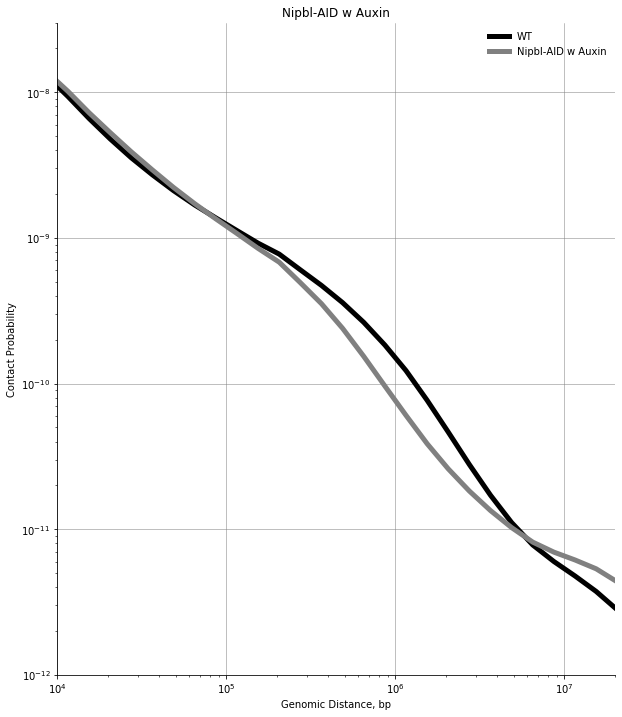

In [8]:
colorMap = {"Nipbl-AID w Auxin": "grey",
            "WT": "black"}

f, ax = plt.subplots()
plt.subplots_adjust(wspace=0.7)
for index, sample in enumerate(scs.keys()):
        sc = scs[sample]
        sc_agg = (sc[0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
        ax.loglog(
            np.sqrt(sc_agg.min_dist * sc_agg.max_dist),
            sc_agg.n_pairs / sc_agg.n_bp2,
            label=f'{sample}',
            linewidth=5, color=colorMap[sample])
ax.grid(lw=0.5, color='gray')
ax.set_xlim(10**4, 2*10**7)
ax.set_ylim(10**-12, 3 * 10**-8)
ax.legend(frameon=False)
ax.set_xlabel("Genomic Distance, bp")
ax.set_ylabel("Contact Probability")
ax.set_title(sample)
f.set_size_inches(10, 12)
sbn.despine()
plt.show()